### Toronto Data Analysis

In [2]:
import numpy as np
import pandas as pd
import requests
import lxml
! pip install folium==0.5.0
import folium
import matplotlib.pyplot as plt
import seaborn as sns
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import warnings

from tqdm import tqdm
from IPython.display import Image 
from IPython.core.display import HTML
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup

warnings.filterwarnings('ignore')

from tqdm import tqdm
import sys
import linecache

def PrintException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print('EXCEPTION IN ({}, LINE {} "{}"): {}'.format(filename, lineno, line.strip(), exc_obj))

%matplotlib inline

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 79 kB 8.7 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=2e4ab64d902175677160cd659ac65cd02b98b7e3b1a26c7f9c2b0860a1e9c20b
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptog

Data Processing : In order to learn about the neighborhood we use Wikipedia to Identify the list of neighborhoods in the city of Toronto.

In [119]:
# Finding the postals codes, neighborhoods in Toronto, Canada
List_url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(List_url).text          
soup = BeautifulSoup(source, 'xml')
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
toronto_data=pd.DataFrame(table_contents)
toronto_data['Borough']=toronto_data['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
toronto_data['latitude'] = None
toronto_data['longitude'] = None
toronto_data.head()

,PostalCode,Borough,Neighborhood,latitude,longitude
0,M3A,North York,Parkwoods,None,None
1,M4A,North York,Victoria Village,None,None
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",None,None
3,M6A,North York,"Lawrence Manor, Lawrence Heights",None,None
4,M7A,Queen's Park,Ontario Provincial Government,None,None


In [120]:
toronto_data = toronto_data.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
toronto_data.head()
print("Shape: ", toronto_data.shape)

Shape:  (103, 3)


In [121]:
geo_df=pd.read_csv('https://cocl.us/Geospatial_data')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [122]:
df_toronto = pd.merge(toronto_data, geo_df, how='left', left_on = 'PostalCode', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head(20)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [20]:
toronto_data=df_toronto[df_toronto['Borough'].str.contains("Toronto")]
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923


In [21]:
CLIENT_ID = 'ZWLUMWV501SDT51L0ZTVQUTKGN2PDK1ZNCKVLRGR4JNDKVBI' # your Foursquare ID
CLIENT_SECRET = 'MYA2VVZZPIROHNIFGA30DX50YR0DFIHEB5UUEHLVJQ52YBCK' # your Foursquare Secret
VERSION = '20180604'

In [22]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [108]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

The Beaches
The Danforth  East
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Enclave of M5E
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction 

In [25]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,60,60,60,60,60,60
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,62,62,62,62,62,62
Christie,16,16,16,16,16,16
Church and Wellesley,76,76,76,76,76,76
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34
Davisville North,9,9,9,9,9,9


In [30]:


# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
toronto_onehot.insert(loc=0, column='Neighborhood', value=toronto_venues['Neighborhood'] )
toronto_onehot.shape

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()



,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.0,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.016667,0.0,0.0,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0625,0.0625,0.0625,0.0625,0.125,0.125,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,Central Bay Street,0.0,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.016129,0.016129
4,Christie,0.0,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Farmers Market,Restaurant,Cheese Shop,Pharmacy,Beer Bar,Diner
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Breakfast Spot,Nightclub,Coffee Shop,Furniture / Home Store,Convenience Store,Restaurant,Italian Restaurant,Stadium
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Boutique,Coffee Shop,Airport,Airport Food Court,Airport Gate,Airport Lounge,Sculpture Garden,Harbor / Marina
3,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Japanese Restaurant,Salad Place,Burger Joint,Bubble Tea Shop,Pizza Place,Poke Place
4,Christie,Grocery Store,Café,Park,Coffee Shop,Italian Restaurant,Bank,Candy Store,Baby Store,Restaurant,Nightclub


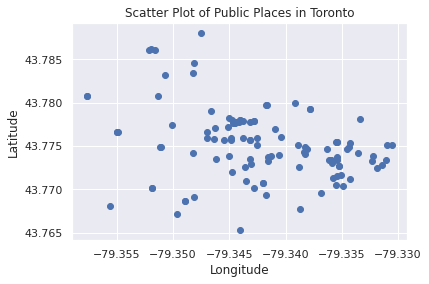

In [33]:
lat_data = data['lat']
lng_data = data['lng']
neighborhood = data['neighborhood'].apply(lambda x: x.split(',')[0])

plt.scatter(lng_data, lat_data)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatter Plot of Public Places in Toronto')
plt.savefig('Public_Places_Scatter_Plot.png')
plt.show()

In [34]:
general_location = geolocator.geocode('Toronto')
geolocator = Nominatim(user_agent="coursera_capstone_project", timeout=1000)
venues_map = folium.Map(location=[43.653908, -79.384293], zoom_start=11)

for neighborhood, location in locations.items():
    folium.CircleMarker(
        [location[0], location[1]],
        radius=5,
        color='red',
        popup=neighborhood,
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.6
    ).add_to(venues_map)
    
venues_map

In [37]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [38]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Farmers Market,Restaurant,Cheese Shop,Pharmacy,Beer Bar,Diner
1,"Brockton, Parkdale Village, Exhibition Place",Café,Bakery,Breakfast Spot,Nightclub,Coffee Shop,Furniture / Home Store,Convenience Store,Restaurant,Italian Restaurant,Stadium
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Boutique,Coffee Shop,Airport,Airport Food Court,Airport Gate,Airport Lounge,Sculpture Garden,Harbor / Marina
3,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Japanese Restaurant,Salad Place,Burger Joint,Bubble Tea Shop,Pizza Place,Poke Place
4,Christie,Grocery Store,Café,Park,Coffee Shop,Italian Restaurant,Bank,Candy Store,Baby Store,Restaurant,Nightclub


In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_data_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_data_merged = toronto_data_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_data_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Electronics Store
40,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,2,Park,Convenience Store,Yoga Studio,Distribution Center,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Bubble Tea Shop,Indian Restaurant,Spa,Cosmetics Shop,Juice Bar
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Fast Food Restaurant,Pet Store,Movie Theater,Sandwich Place,Italian Restaurant,Restaurant,Fish & Chips Shop,Steakhouse,Ice Cream Shop,Brewery
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Music Store


In [41]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Manhattan are 43.6534817, -79.3839347.


In [46]:
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_data_merged['Latitude'], toronto_data_merged['Longitude'], toronto_data_merged['Neighborhood'], toronto_data_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [75]:
toronto_data_merged.loc[toronto_data_merged['Cluster Labels'] == 0, toronto_data_merged.columns[[1] + list(range(5, toronto_data_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,0,Health Food Store,Trail,Pub,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Electronics Store
41,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Bubble Tea Shop,Indian Restaurant,Spa,Cosmetics Shop,Juice Bar
42,East Toronto,0,Fast Food Restaurant,Pet Store,Movie Theater,Sandwich Place,Italian Restaurant,Restaurant,Fish & Chips Shop,Steakhouse,Ice Cream Shop,Brewery
43,East Toronto,0,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Music Store
44,Central Toronto,0,Construction & Landscaping,Park,Bus Line,Swim School,Yoga Studio,Distribution Center,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room
45,Central Toronto,0,Gym / Fitness Center,Breakfast Spot,Hotel,Food & Drink Shop,Department Store,Park,Playground,Sandwich Place,Pizza Place,Antique Shop
46,Central Toronto,0,Clothing Store,Coffee Shop,Yoga Studio,Ice Cream Shop,Salon / Barbershop,Restaurant,Rental Car Location,Park,Mexican Restaurant,Gift Shop
47,Central Toronto,0,Pizza Place,Dessert Shop,Sandwich Place,Coffee Shop,Sushi Restaurant,Café,Gym,Italian Restaurant,Park,Pharmacy
49,Central Toronto,0,Coffee Shop,Sushi Restaurant,American Restaurant,Supermarket,Light Rail Station,Pub,Fried Chicken Joint,Restaurant,Bank,Bagel Shop
51,Downtown Toronto,0,Coffee Shop,Park,Restaurant,Pub,Italian Restaurant,Bakery,Pizza Place,Café,Gastropub,Indian Restaurant


In [58]:
toronto_data_merged.loc[toronto_data_merged['Cluster Labels'] == 1, toronto_data_merged.columns[[1] + list(range(5, toronto_data_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,1,Restaurant,Park,Trail,Summer Camp,Diner,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


In [59]:
toronto_data_merged.loc[toronto_data_merged['Cluster Labels'] == 2, toronto_data_merged.columns[[1] + list(range(5, toronto_data_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,East York/East Toronto,2,Park,Convenience Store,Yoga Studio,Distribution Center,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store
50,Downtown Toronto,2,Park,Playground,Trail,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


In [60]:
toronto_data_merged.loc[toronto_data_merged['Cluster Labels'] == 3, toronto_data_merged.columns[[1] + list(range(5, toronto_data_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Central Toronto,3,Trail,Jewelry Store,Mexican Restaurant,Sushi Restaurant,Yoga Studio,Discount Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store


In [61]:
toronto_data_merged.loc[toronto_data_merged['Cluster Labels'] == 4, toronto_data_merged.columns[[1] + list(range(5, toronto_data_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,4,Music Venue,Pool,Home Service,Garden,Diner,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


### Newyork Data Analysis

In [76]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [77]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [79]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [80]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [81]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [82]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [83]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [84]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [85]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [86]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

In [87]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


In [89]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron


In [90]:
print(manhattan_venues.shape)
manhattan_venues.head()

(1583, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,Marble Hill,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,Marble Hill,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,Marble Hill,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,Chinatown,43.685347,-79.338106,Aldwych Park,43.684901,-79.341091,Park


In [91]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,16,16,16,16,16,16
Carnegie Hill,100,100,100,100,100,100
Central Harlem,9,9,9,9,9,9
Chelsea,60,60,60,60,60,60
Chinatown,3,3,3,3,3,3
Civic Center,15,15,15,15,15,15
Clinton,43,43,43,43,43,43
East Harlem,20,20,20,20,20,20
East Village,94,94,94,94,94,94


In [92]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 234 uniques categories.


In [93]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Yoga Studio,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Battery Park City,0.000000,0.000000,0.0625,0.0625,0.0625,0.0625,0.125,0.125,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
1,Carnegie Hill,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.030000,...,0.010000,0.000000,0.00000,0.000000,0.00000,0.01,0.010000,0.00000,0.000000,0.010000
2,Central Harlem,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
3,Chelsea,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.016667,0.00000,0.000000,0.000000
4,Chinatown,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
5,Civic Center,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
6,Clinton,0.023256,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000000,...,0.046512,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
7,East Harlem,0.050000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.00000,0.000000,0.000000
8,East Village,0.000000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.021277,...,0.010638,0.000000,0.00000,0.000000,0.00000,0.00,0.010638,0.00000,0.000000,0.000000
9,Financial District,0.010000,0.000000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.00000,0.00,0.010000,0.00000,0.000000,0.000000


In [95]:
num_top_venues = 5

for hood in manhattan_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                 venue  freq
0      Airport Service  0.12
1     Airport Terminal  0.12
2                Plane  0.06
3  Rental Car Location  0.06
4              Airport  0.06


----Carnegie Hill----
                 venue  freq
0          Coffee Shop  0.11
1                 Café  0.07
2                Hotel  0.06
3           Restaurant  0.04
4  Japanese Restaurant  0.04


----Central Harlem----
                  venue  freq
0  Gym / Fitness Center  0.11
1                 Hotel  0.11
2            Playground  0.11
3                  Park  0.11
4      Department Store  0.11


----Chelsea----
            venue  freq
0     Coffee Shop  0.10
1    Cocktail Bar  0.07
2          Bakery  0.05
3  Farmers Market  0.03
4      Restaurant  0.03


----Chinatown----
                 venue  freq
0                 Park  0.67
1    Convenience Store  0.33
2          Yoga Studio  0.00
3               Museum  0.00
4  Martial Arts School  0.00


----Civic Center----
                  

In [96]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [97]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Airport Terminal,Airport Service,Sculpture Garden,Plane,Boat or Ferry,Rental Car Location,Boutique,Harbor / Marina,Coffee Shop,Airport Lounge
1,Carnegie Hill,Coffee Shop,Café,Hotel,Gym,Japanese Restaurant,Restaurant,Steakhouse,Seafood Restaurant,American Restaurant,Salad Place
2,Central Harlem,Department Store,Park,Pizza Place,Gym / Fitness Center,Breakfast Spot,Playground,Food & Drink Shop,Hotel,Sandwich Place,Dog Run
3,Chelsea,Coffee Shop,Cocktail Bar,Bakery,Pharmacy,Cheese Shop,Restaurant,Seafood Restaurant,Beer Bar,Farmers Market,Gourmet Shop
4,Chinatown,Park,Convenience Store,Wine Bar,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


In [98]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [99]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,0.0,Trail,Pub,Health Food Store,Wine Bar,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Eastern European Restaurant
1,Manhattan,Chinatown,40.715618,-73.994279,1.0,Park,Convenience Store,Wine Bar,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,0.0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Indian Restaurant,Spa,Bookstore,Juice Bar,Brewery
3,Manhattan,Inwood,40.867684,-73.921210,0.0,Fast Food Restaurant,Gym,Food & Drink Shop,Liquor Store,Sandwich Place,Italian Restaurant,Restaurant,Fish & Chips Shop,Ice Cream Shop,Steakhouse
4,Manhattan,Hamilton Heights,40.823604,-73.949688,0.0,Coffee Shop,Café,Bakery,Gastropub,American Restaurant,Brewery,Yoga Studio,Ice Cream Shop,Fish Market,Italian Restaurant


In [102]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

In [103]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Trail,Pub,Health Food Store,Wine Bar,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Eastern European Restaurant
2,Washington Heights,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Indian Restaurant,Spa,Bookstore,Juice Bar,Brewery
3,Inwood,Fast Food Restaurant,Gym,Food & Drink Shop,Liquor Store,Sandwich Place,Italian Restaurant,Restaurant,Fish & Chips Shop,Ice Cream Shop,Steakhouse
4,Hamilton Heights,Coffee Shop,Café,Bakery,Gastropub,American Restaurant,Brewery,Yoga Studio,Ice Cream Shop,Fish Market,Italian Restaurant
6,Central Harlem,Department Store,Park,Pizza Place,Gym / Fitness Center,Breakfast Spot,Playground,Food & Drink Shop,Hotel,Sandwich Place,Dog Run
7,East Harlem,Coffee Shop,Clothing Store,Yoga Studio,Salon / Barbershop,Restaurant,Rental Car Location,Café,Chinese Restaurant,Park,Sporting Goods Shop
8,Upper East Side,Pizza Place,Dessert Shop,Sandwich Place,Gym,Café,Italian Restaurant,Sushi Restaurant,Coffee Shop,Diner,Farmers Market
10,Lenox Hill,Coffee Shop,Sushi Restaurant,American Restaurant,Bank,Pub,Supermarket,Light Rail Station,Fried Chicken Joint,Restaurant,Bagel Shop
12,Upper West Side,Restaurant,Park,Coffee Shop,Café,Italian Restaurant,Pizza Place,Bakery,Pub,Sandwich Place,Convenience Store
13,Lincoln Square,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Pub,Hotel,Fast Food Restaurant,Dance Studio,Yoga Studio


In [104]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Chinatown,Park,Convenience Store,Wine Bar,Discount Store,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant
11,Roosevelt Island,Park,Playground,Trail,Wine Bar,Dessert Shop,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [105]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Yorkville,Restaurant,Park,Trail,Summer Camp,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [106]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Soho,Home Service,Music Venue,Garden,Pool,Wine Bar,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop


In [107]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Manhattanville,Swim School,Park,Construction & Landscaping,Bus Line,Wine Bar,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant


### Analysis for best restaurant place in Toronto

In [117]:
# Load this data from Stats Canada
df_pop = pd.read_csv('https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Tables/File.cfm?T=1201&SR=1&RPP=9999&PR=0&CMA=0&CSD=0&S=22&O=A&Lang=Eng&OFT=CSV',encoding = 'unicode_escape')
# Rename the columns appropiatley
df_pop = df_pop.rename(columns={'Geographic code':'PostalCode', 'Geographic name':'PostalCod2', 'Province or territory':'Province', 'Incompletely enumerated Indian reserves and Indian settlements, 2016':'Incomplete', 'Population, 2016':'Population_2016', 'Total private dwellings, 2016':'TotalPrivDwellings', 'Private dwellings occupied by usual residents, 2016':'PrivDwellingsOccupied'})
df_pop= df_pop.drop(columns=['PostalCod2', 'Province', 'Incomplete', 'TotalPrivDwellings', 'PrivDwellingsOccupied'])

# Get rid of the first row 
df_pop = df_pop.iloc[1:]
df_pop.head()

,PostalCode,Population_2016
1,A0A,46587.0
2,A0B,19792.0
3,A0C,12587.0
4,A0E,22294.0
5,A0G,35266.0


In [126]:
gf_new = pd.merge(df_pop, df_toronto, on='PostalCode', how='right')
# sort on population
gf_new = gf_new.sort_values(by=['Population_2016'], ascending=False)

# display the new dataframe
gf_new.head()

,PostalCode,Population_2016,Borough,Neighborhood,Latitude,Longitude
22,M2N,75897.0,North York,Willowdale South,43.770120,-79.408493
0,M1B,66108.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
18,M2J,58293.0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
100,M9V,55959.0,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
14,M1V,54680.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577


In [128]:
TO_data = gf_new
TO_data.head()

,PostalCode,Population_2016,Borough,Neighborhood,Latitude,Longitude
22,M2N,75897.0,North York,Willowdale South,43.770120,-79.408493
0,M1B,66108.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
18,M2J,58293.0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
100,M9V,55959.0,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
14,M1V,54680.0,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577


In [129]:
TO_venues = getNearbyVenues(names=TO_data['Neighborhood'],
                                   latitudes=TO_data['Latitude'],
                                   longitudes=TO_data['Longitude']
                                  )

Willowdale South
Malvern, Rouge
Fairview, Henry Farm, Oriole
South Steeles, Silverstone, Humbergate, Jamestown, Mount Olive, Beaumond Heights, Thistletown, Albion Gardens
Milliken, Agincourt North, Steeles East, L'Amoreaux East
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Steeles West, L'Amoreaux West
Kennedy Park, Ionview, East Birchmount Park
Guildwood, Morningside, West Hill
Woodbine Heights
Dorset Park, Wexford Heights, Scarborough Town Centre
Dufferin, Dovercourt Village
Del Ray, Mount Dennis, Keelsdale and Silverthorn
Downsview Northwest
Runnymede, The Junction North
Regent Park, Harbourfront
Brockton, Parkdale Village, Exhibition Place
Willowdale West
Clairville, Humberwood, Woodbine Downs, West Humber, Kipling Heights, Rexdale, Elms, Tandridge, Old Rexdale
High Park, The Junction South
Don Mills South
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Caledonia-Fairbanks
New Toronto, Mimico South, Humber B

In [130]:
TO_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",25,25,25,25,25,25
...,...,...,...,...,...,...
Willowdale South,34,34,34,34,34,34
Willowdale West,6,6,6,6,6,6
Woburn,3,3,3,3,3,3


In [131]:
# Let's pick out restaurants from Venue Categories

print('Unique Venue Categories:')
list(TO_venues['Venue Category'].unique())

Unique Venue Categories:


['Grocery Store',
 'Ramen Restaurant',
 'Coffee Shop',
 'Café',
 'Movie Theater',
 'Plaza',
 'Ice Cream Shop',
 'Japanese Restaurant',
 'Juice Bar',
 'Shopping Mall',
 'Lounge',
 'Fast Food Restaurant',
 'Sushi Restaurant',
 'Pet Store',
 'Arts & Crafts Store',
 'Discount Store',
 'Electronics Store',
 'Restaurant',
 'Bank',
 'Middle Eastern Restaurant',
 'Pizza Place',
 'Sandwich Place',
 'Vietnamese Restaurant',
 'Bubble Tea Shop',
 'Liquor Store',
 'Hotel',
 'Korean Restaurant',
 'Toy / Game Store',
 'Chocolate Shop',
 'Pharmacy',
 'Bakery',
 'Salon / Barbershop',
 'Burger Joint',
 'Department Store',
 'American Restaurant',
 'Clothing Store',
 'Theater',
 'Food Court',
 'Video Game Store',
 'Asian Restaurant',
 'Cosmetics Shop',
 'Burrito Place',
 'Sporting Goods Shop',
 'Bar',
 "Women's Store",
 'Deli / Bodega',
 'Boutique',
 'Supplement Shop',
 'Shoe Store',
 'Luggage Store',
 'Jewelry Store',
 'Chinese Restaurant',
 'Accessories Store',
 'Bus Station',
 'Convenience Store',
 'In

In [132]:
# Here we manually pick out restaurants or 'features' from the unique venue list and that we want to examine for similiarity during clustering
rest_list = ['Steakhouse', 'Coffee Shop', 'Café', 'Ramen Restaurant', 'Indonesian Restaurant', 'Restaurant', 'Japanese Restaurant', 
             'Fast Food Restaurant', 'Sushi Restaurant', 'Vietnamese Restaurant', 'Pizza Place', 'Sandwich Place', 'Middle Eastern Restaurant', 
             'Burger Joint', 'American Restaurant', 'Food Court', 'Wings Joint', 'Burrito Place', 'Asian Restaurant', 'Deli / Bodega', 
             'Greek Restaurant', 'Fried Chicken Joint', 'Airport Food Court', 'Chinese Restaurant', 'Breakfast Spot', 'Mexican Restaurant',
             'Indian Restaurant', 'Latin American Restaurant', 'Bar', 'Pub', 'Italian Restaurant', 'French Restaurant', 'Ice Cream Shop', 
             'Caribbean Restaurant', 'Gastropub', 'Thai Restaurant', 'Cajun / Creole Restaurant', 'Diner', 'Dim Sum Restaurant', 'Seafood Restaurant', 
             'Food & Drink Shop', 'Noodle House', 'Food', 'Fish & Chips Shop', 'Falafel Restaurant', 'Gourmet Shop', 'Vegetarian / Vegan Restaurant', 
             'South American Restaurant', 'Korean Restaurant', 'Cuban Restaurant', 'New American Restaurant', 'Malay Restaurant', 'Mac & Cheese Joint',
             'Bistro', 'Southern / Soul Food Restaurant', 'Tapas Restaurant',  'Sports Bar', 'Polish Restaurant', 'Ethiopian Restaurant', 
             'Creperie', 'Sake Bar', 'Persian Restaurant', 'Afghan Restaurant','Mediterranean Restaurant', 'BBQ Joint', 'Jewish Restaurant', 
             'Comfort Food Restaurant',  'Hakka Restaurant', 'Food Truck', 'Taiwanese Restaurant',  'Snack Place', 'Eastern European Restaurant', 
             'Dumpling Restaurant', 'Belgian Restaurant', 'Arepa Restaurant', 'Taco Place', 'Doner Restaurant', 'Filipino Restaurant', 
             'Hotpot Restaurant', 'Poutine Place', 'Salad Place',  'Portuguese Restaurant', 'Modern European Restaurant', 'Empanada Restaurant', 
             'Irish Pub', 'Molecular Gastronomy Restaurant', 'German Restaurant', 'Brazilian Restaurant', 'Gluten-free Restaurant', 'Soup Place']

rest_pd = pd.DataFrame(rest_list)
#rest_pd
#rename the coloumns so the match
rest_pd = rest_pd.rename(columns={0:'Venue Category'})

#Join the 2 dataframes as instructed
TO_new = pd.merge(TO_venues, rest_pd, on='Venue Category', how='right')

# display the new dataframe
#TO_new

TO_new.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,2,2,2,2,2,2
"Alderwood, Long Branch",5,5,5,5,5,5
"Bathurst Manor, Wilson Heights, Downsview North",11,11,11,11,11,11
Bayview Village,3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",18,18,18,18,18,18
...,...,...,...,...,...,...
Westmount,5,5,5,5,5,5
"Wexford, Maryvale",3,3,3,3,3,3
Willowdale South,19,19,19,19,19,19


In [133]:
# one hot encoding
TO_new_onehot = pd.get_dummies(TO_new[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
TO_new_onehot['Neighborhood'] = TO_new['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [TO_new_onehot.columns[-1]] + list(TO_new_onehot.columns[:-1])
TO_new_onehot = TO_new_onehot[fixed_columns]

TO_new_onehot.head()

,Neighborhood,Afghan Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bar,Belgian Restaurant,Bistro,...,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Willowdale South,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Willowdale South,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Willowdale South,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Church and Wellesley,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Garden District, Ryerson",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:


#Analyze each neighbourhood



TO_grouped = TO_new_onehot.groupby('Neighborhood').mean().reset_index()
TO_grouped.shape


TO_grouped.head()



,Neighborhood,Afghan Restaurant,Airport Food Court,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bar,Belgian Restaurant,Bistro,...,Sports Bar,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Agincourt,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.090909,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.055556,0.0,0.0,0.0,0.055556,0.0,0.0,0.0


In [137]:
from sklearn.metrics import silhouette_score
TO_grouped_clustering = TO_grouped.drop('Neighborhood', 1)

# Use silhouette score to find optimal number of clusters to segment the data
kclusters = np.arange(2,10)
results = {}
for size in kclusters:
    model = KMeans(n_clusters = size).fit(TO_grouped_clustering)
    predictions = model.predict(TO_grouped_clustering)
    results[size] = silhouette_score(TO_grouped_clustering, predictions)

best_size = max(results, key=results.get)
best_size

6

In [138]:
kclusters = best_size


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(TO_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 2, 2, 2, 2, 2, 2, 3, 0], dtype=int32)

In [139]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = TO_grouped['Neighborhood']

for ind in np.arange(TO_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(TO_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Food,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant
1,"Alderwood, Long Branch",Pizza Place,Pub,Coffee Shop,Sandwich Place,Falafel Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Pizza Place,Sandwich Place,Diner,Fried Chicken Joint,Ice Cream Shop,Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Deli / Bodega
3,Bayview Village,Chinese Restaurant,Japanese Restaurant,Café,Wings Joint,Fish & Chips Shop,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant
4,"Bedford Park, Lawrence Manor East",Restaurant,Sandwich Place,Italian Restaurant,Coffee Shop,Pub,Café,Fast Food Restaurant,Indian Restaurant,Pizza Place,Comfort Food Restaurant


In [140]:
#Merge the Toronto data with geo cooridinate data and make sure it's the right shape
TO_labels = pd.merge(TO_data,TO_grouped, on='Neighborhood', how='right')
TO_labels.shape


TO_labels = TO_labels.drop(columns=['Steakhouse', 'Coffee Shop', 'Café', 'Ramen Restaurant', 'Indonesian Restaurant', 'Restaurant', 'Japanese Restaurant', 
             'Fast Food Restaurant', 'Sushi Restaurant', 'Vietnamese Restaurant', 'Pizza Place', 'Sandwich Place', 'Middle Eastern Restaurant', 
             'Burger Joint', 'American Restaurant', 'Food Court', 'Wings Joint', 'Burrito Place', 'Asian Restaurant', 'Deli / Bodega', 
             'Greek Restaurant', 'Fried Chicken Joint', 'Airport Food Court', 'Chinese Restaurant', 'Breakfast Spot', 'Mexican Restaurant',
             'Indian Restaurant', 'Latin American Restaurant', 'Bar', 'Pub', 'Italian Restaurant', 'French Restaurant', 'Ice Cream Shop', 
             'Caribbean Restaurant', 'Gastropub', 'Thai Restaurant', 'Cajun / Creole Restaurant', 'Diner', 'Dim Sum Restaurant', 'Seafood Restaurant', 
             'Food & Drink Shop', 'Noodle House', 'Food', 'Fish & Chips Shop', 'Falafel Restaurant', 'Gourmet Shop', 'Vegetarian / Vegan Restaurant', 
             'South American Restaurant', 'Korean Restaurant', 'Cuban Restaurant', 'New American Restaurant', 'Malay Restaurant', 'Mac & Cheese Joint',
             'Bistro', 'Southern / Soul Food Restaurant', 'Tapas Restaurant',  'Sports Bar', 'Polish Restaurant', 'Ethiopian Restaurant', 
             'Creperie', 'Sake Bar', 'Persian Restaurant', 'Afghan Restaurant','Mediterranean Restaurant', 'BBQ Joint', 'Jewish Restaurant', 
             'Comfort Food Restaurant',  'Hakka Restaurant', 'Food Truck', 'Taiwanese Restaurant',  'Snack Place', 'Eastern European Restaurant', 
             'Dumpling Restaurant', 'Belgian Restaurant', 'Arepa Restaurant', 'Taco Place', 'Doner Restaurant', 'Filipino Restaurant', 
             'Hotpot Restaurant', 'Poutine Place', 'Salad Place',  'Portuguese Restaurant', 'Modern European Restaurant', 'Empanada Restaurant', 
             'Irish Pub', 'Molecular Gastronomy Restaurant', 'German Restaurant', 'Brazilian Restaurant', 'Gluten-free Restaurant', 'Soup Place'])
TO_labels.head()

,PostalCode,Population_2016,Borough,Neighborhood,Latitude,Longitude
0,M2N,75897.0,North York,Willowdale South,43.770120,-79.408493
1,M1B,66108.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353
2,M2J,58293.0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
3,M9V,55959.0,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
4,M5V,49195.0,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420


In [141]:
TO_merged = TO_labels

# add clustering labels
TO_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
TO_merged = TO_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

TO_merged.head() # check the last columns!

,PostalCode,Population_2016,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M2N,75897.0,North York,Willowdale South,43.770120,-79.408493,2,Ramen Restaurant,Coffee Shop,Café,Pizza Place,Sushi Restaurant,Restaurant,Sandwich Place,Japanese Restaurant,Fast Food Restaurant,Middle Eastern Restaurant
1,M1B,66108.0,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1,Fast Food Restaurant,Wings Joint,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant,Filipino Restaurant
2,M2J,58293.0,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,2,Fast Food Restaurant,Coffee Shop,Restaurant,Japanese Restaurant,Food Court,Sandwich Place,Burrito Place,Burger Joint,Chinese Restaurant,Bar
3,M9V,55959.0,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437,2,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Pizza Place,Wings Joint,Diner,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
4,M5V,49195.0,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,2,Airport Food Court,Bar,Coffee Shop,Wings Joint,Food,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Falafel Restaurant


In [143]:
TO_merged_new1 = TO_merged.loc[TO_merged['Cluster Labels'] == 0, TO_merged.columns[[3, 4] + list(range(5, TO_merged.shape[1]))]]
TO_merged_new1.shape

(22, 14)

In [144]:
TO_merged_new2 = TO_merged.loc[TO_merged['Cluster Labels'] == 1, TO_merged.columns[[3, 4] + list(range(5, TO_merged.shape[1]))]]
TO_merged_new2.shape

(6, 14)

In [145]:
# Find the geographic center of the most dense or like cluster.
Cluster_0_coorid = TO_merged_new2[['Latitude', 'Longitude']]
Cluster_0_coorid = list(Cluster_0_coorid.values) 
lat = []
long = []



for l in Cluster_0_coorid:
  lat.append(l[0])
  long.append(l[1])



Blatitude = sum(lat)/len(lat)
Blongitude = sum(long)/len(long)
print(Blatitude)
print(Blongitude)

43.67699820000001
-79.35801218333334


In [155]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.6534817, -79.3839347.


In [156]:
import folium 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(TO_merged['Latitude'], TO_merged['Longitude'], TO_merged['Neighborhood'], TO_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
folium.CircleMarker([Blatitude, Blongitude],
                    radius=50,
                    popup='Toronto',
                    color='red',
                    ).add_to(map_clusters)

map_clusters
